In [31]:
print("Hello world")

Hello world


In [32]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader



In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [34]:
class SemArtDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.image_files = dataframe['IMAGE_FILE'].values
        self.labels = dataframe['TYPE'].values
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.base_path, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats/defaults
    #Add other augmentations later
])


In [36]:
# Load CSV files
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
val_df = pd.read_csv("data/semart_val.csv", sep="\t", encoding="ISO-8859-1")

# Hard-code the classes to focus on: 'religious', 'portrait', 'landscape',"still-life","mythological'
#We need to recude the scope
target_classes = ['religious', 'portrait', 'landscape',"still-life","mythological"]

# Filter the DataFrames to include only these three classes
train_df = train_df[train_df['TYPE'].isin(target_classes)]
val_df = val_df[val_df['TYPE'].isin(target_classes)]
test_df = test_df[test_df['TYPE'].isin(target_classes)]

original_class_labels = train_df['TYPE'].unique()




In [ ]:
# Take the first 2 images?? Use the same images for the val set??
train_df = train_df.head(2)
test_df = train_df.copy()
val_df = train_df.copy()

In [ ]:
# Label encoding
le = LabelEncoder()
train_df['TYPE'] = le.fit_transform(train_df['TYPE'])
test_df['TYPE'] = le.transform(test_df['TYPE'])
val_df['TYPE'] = le.transform(val_df['TYPE'])

encoded_to_original = dict(zip(range(len(le.classes_)), le.classes_))

# Load dataset
base_path = 'processed_imagesV2/'
train_dataset = SemArtDataset(train_df, base_path, transform=transform)
val_dataset = SemArtDataset(val_df, base_path, transform=transform)
test_dataset = SemArtDataset(test_df, base_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
def overfit_test(train_loader, val_loader, learning_rate=1e-4,  amount_of_nodes = 4096):
    """
    Conducts an overfitting test on a small dataset to validate the training process.
    (...)

    # When you have a network, train your model with 2 images. The loss should approach 0.0. We expect the model to overfit.

    # It may take time, and the loss will gradually approach 0.0.

    # The model should overfit on at least 1 sample, but the goal is not to overfit.

    Args:
        train: Training dataset 
        validation: Validation dataset 
        amount_of_nodes: Number of nodes at the end default 4096.
        learning_rate: Learning rate for the optimizer.

    Returns:
        image: 
    """
    model = models.vgg16(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    num_classes = len(np.unique(train_df['TYPE']))  

    # Default classifier (but we want change the amount of nodes)
    new_classifier = nn.Sequential(
        nn.Linear(25088, amount_of_nodes),  # First fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, amount_of_nodes),  # Second fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, num_classes)   # Output layer (for 1000 classes, modify if needed)
    )

    # Replace the original classifier
    model.classifier = new_classifier

    # Move model to device (GPU or CPU)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) 

    num_epochs = 10
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_validation_loss = np.inf

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # Wrap the train_loader with tqdm for progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
                
                # Update the progress bar description
                #progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct_preds / total_preds)
        
        # Calculate training loss and accuracy
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_accuracy = correct_preds / total_preds
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
                for inputs, labels in val_bar:
                    inputs, labels = inputs.to(device), labels.to(device).long()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Track loss and accuracy
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_preds += labels.size(0)

                    # Update validation progress bar
                    val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)

        # Calculate validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_correct_preds / val_total_preds
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)


        #hoogste opslaan Doe accuracy
        if val_epoch_loss<best_validation_loss:
            print("new best model")
            best_validation_loss = val_epoch_loss
            #torch.save(model, f'trainedmodels\\{naam}.pth')



        #print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss (lr: {learning_rate})")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy (lr: {learning_rate})")
    plt.legend()

    plt.tight_layout()

    #plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

    plt.show()



d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Training: 100%|██████████| 1/1 [00:00<00:00,  1.46batch/s]


Epoch [1/10], Training Loss: 0.6338, Training Accuracy: 0.5000


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.00batch/s, accuracy=1, loss=0]


new best model


Epoch 2/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.13batch/s]


Epoch [2/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 3/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.91batch/s]


Epoch [3/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 4/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 11.48batch/s]


Epoch [4/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 5/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.86batch/s]


Epoch [5/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 6/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.25batch/s]


Epoch [6/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 7/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.24batch/s]


Epoch [7/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 8/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.62batch/s]


Epoch [8/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 9/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.62batch/s]


Epoch [9/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 10/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.30batch/s]


Epoch [10/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 42.81batch/s, accuracy=1, loss=0]


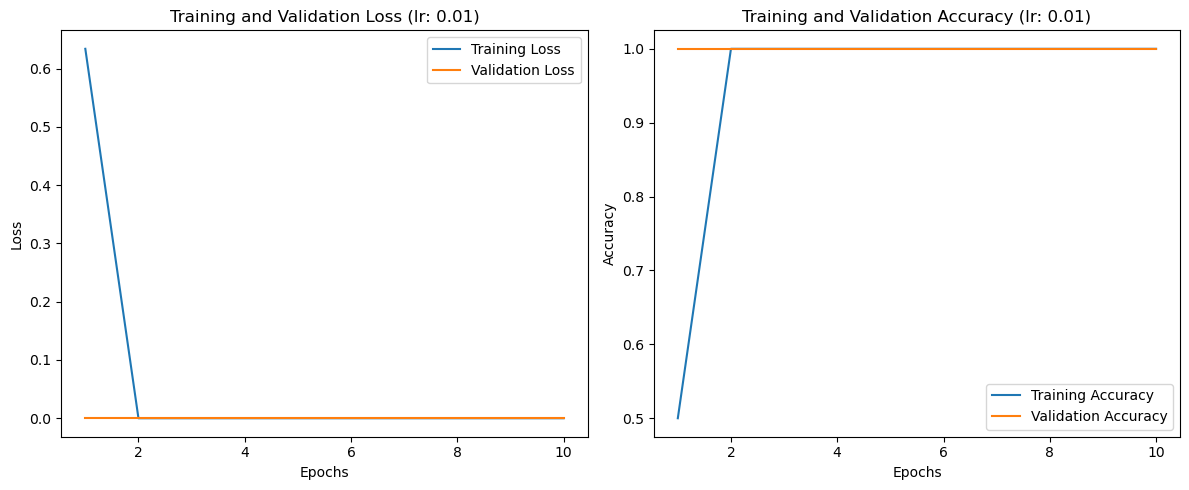

Epoch 1/10 - Training: 100%|██████████| 1/1 [00:00<00:00,  6.54batch/s]


Epoch [1/10], Training Loss: 0.6424, Training Accuracy: 0.5000


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 30.34batch/s, accuracy=1, loss=5.96e-8]


new best model


Epoch 2/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 16.37batch/s]


Epoch [2/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 37.27batch/s, accuracy=1, loss=0]


new best model


Epoch 3/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.84batch/s]


Epoch [3/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 4/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.42batch/s]


Epoch [4/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 5/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.21batch/s]


Epoch [5/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 6/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.89batch/s]


Epoch [6/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 7/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.31batch/s]


Epoch [7/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 8/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.34batch/s]


Epoch [8/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 9/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.63batch/s]


Epoch [9/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 10/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 10.24batch/s]


Epoch [10/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 42.84batch/s, accuracy=1, loss=0]


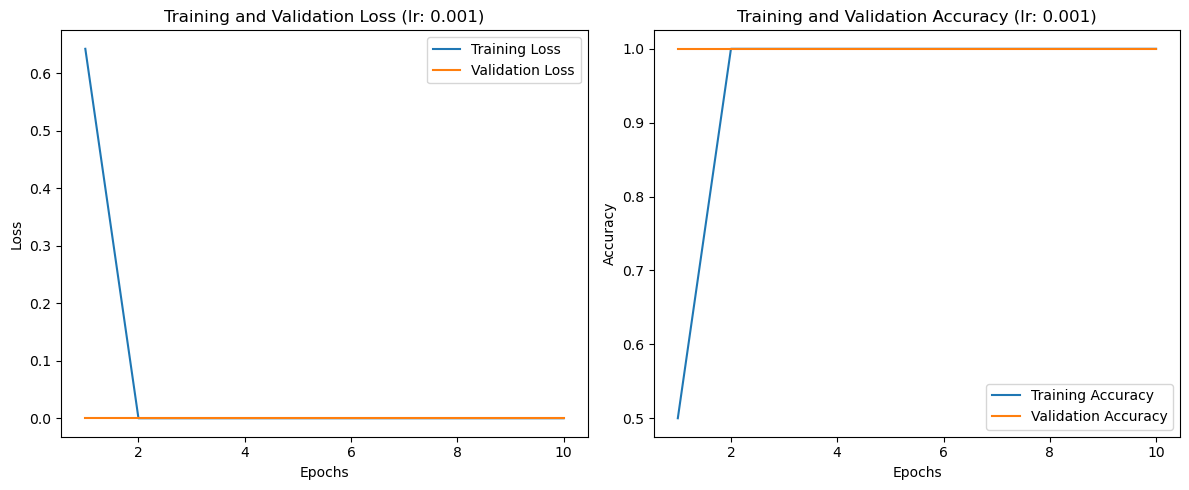

Epoch 1/10 - Training: 100%|██████████| 1/1 [00:00<00:00,  6.94batch/s]


Epoch [1/10], Training Loss: 0.8666, Training Accuracy: 0.5000


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.00batch/s, accuracy=1, loss=0.27]


new best model


Epoch 2/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.37batch/s]


Epoch [2/10], Training Loss: 0.2816, Training Accuracy: 1.0000


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 26.85batch/s, accuracy=1, loss=0.071]


new best model


Epoch 3/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.78batch/s]


Epoch [3/10], Training Loss: 0.0962, Training Accuracy: 1.0000


Epoch 3/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.46batch/s, accuracy=1, loss=0.0132]


new best model


Epoch 4/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.21batch/s]


Epoch [4/10], Training Loss: 0.0288, Training Accuracy: 1.0000


Epoch 4/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 29.38batch/s, accuracy=1, loss=0.00231]


new best model


Epoch 5/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 16.15batch/s]


Epoch [5/10], Training Loss: 0.0053, Training Accuracy: 1.0000


Epoch 5/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 36.88batch/s, accuracy=1, loss=0.000382]


new best model


Epoch 6/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.99batch/s]


Epoch [6/10], Training Loss: 0.0004, Training Accuracy: 1.0000


Epoch 6/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 34.45batch/s, accuracy=1, loss=6.6e-5]


new best model


Epoch 7/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.28batch/s]


Epoch [7/10], Training Loss: 0.0001, Training Accuracy: 1.0000


Epoch 7/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.00batch/s, accuracy=1, loss=1.17e-5]


new best model


Epoch 8/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.95batch/s]


Epoch [8/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 8/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 35.84batch/s, accuracy=1, loss=2.09e-6]


new best model


Epoch 9/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.11batch/s]


Epoch [9/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 9/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 29.12batch/s, accuracy=1, loss=3.58e-7]


new best model


Epoch 10/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.31batch/s]


Epoch [10/10], Training Loss: 0.0000, Training Accuracy: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 28.58batch/s, accuracy=1, loss=5.96e-8]


new best model


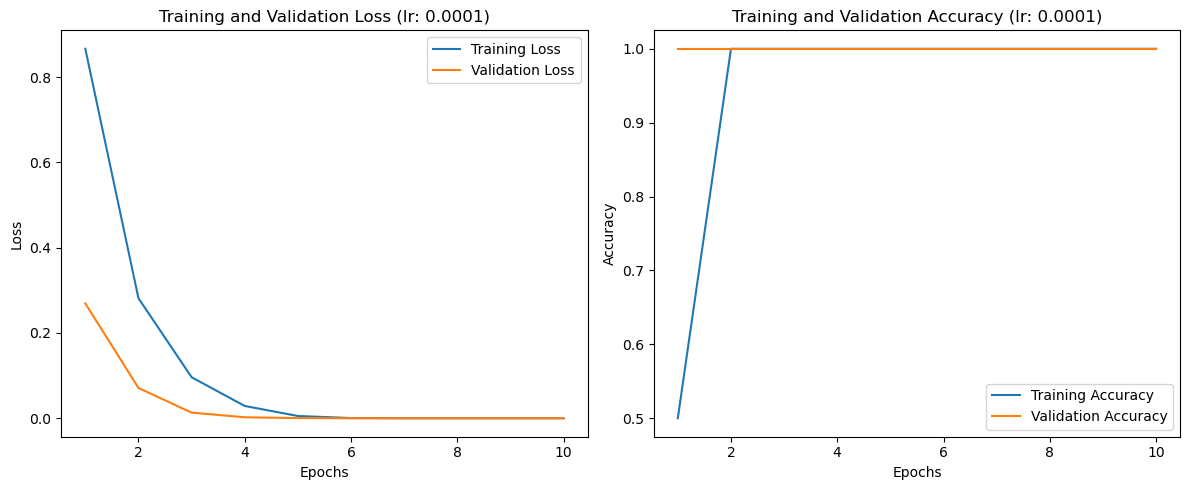

Epoch 1/10 - Training: 100%|██████████| 1/1 [00:00<00:00,  5.15batch/s]


Epoch [1/10], Training Loss: 0.6045, Training Accuracy: 1.0000


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 35.70batch/s, accuracy=1, loss=0.553]


new best model


Epoch 2/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.25batch/s]


Epoch [2/10], Training Loss: 0.6825, Training Accuracy: 0.5000


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 30.52batch/s, accuracy=1, loss=0.473]


new best model


Epoch 3/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.85batch/s]


Epoch [3/10], Training Loss: 0.5492, Training Accuracy: 1.0000


Epoch 3/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 26.34batch/s, accuracy=1, loss=0.4]


new best model


Epoch 4/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.82batch/s]


Epoch [4/10], Training Loss: 0.3469, Training Accuracy: 1.0000


Epoch 4/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 27.29batch/s, accuracy=1, loss=0.337]


new best model


Epoch 5/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.99batch/s]


Epoch [5/10], Training Loss: 0.3678, Training Accuracy: 1.0000


Epoch 5/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 25.43batch/s, accuracy=1, loss=0.283]


new best model


Epoch 6/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.83batch/s]


Epoch [6/10], Training Loss: 0.3362, Training Accuracy: 1.0000


Epoch 6/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 37.22batch/s, accuracy=1, loss=0.237]


new best model


Epoch 7/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.89batch/s]


Epoch [7/10], Training Loss: 0.3085, Training Accuracy: 1.0000


Epoch 7/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 40.39batch/s, accuracy=1, loss=0.199]


new best model


Epoch 8/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.66batch/s]


Epoch [8/10], Training Loss: 0.2181, Training Accuracy: 1.0000


Epoch 8/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 26.47batch/s, accuracy=1, loss=0.168]


new best model


Epoch 9/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.07batch/s]


Epoch [9/10], Training Loss: 0.1768, Training Accuracy: 1.0000


Epoch 9/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.54batch/s, accuracy=1, loss=0.141]


new best model


Epoch 10/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.51batch/s]


Epoch [10/10], Training Loss: 0.2031, Training Accuracy: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 25.84batch/s, accuracy=1, loss=0.119]


new best model


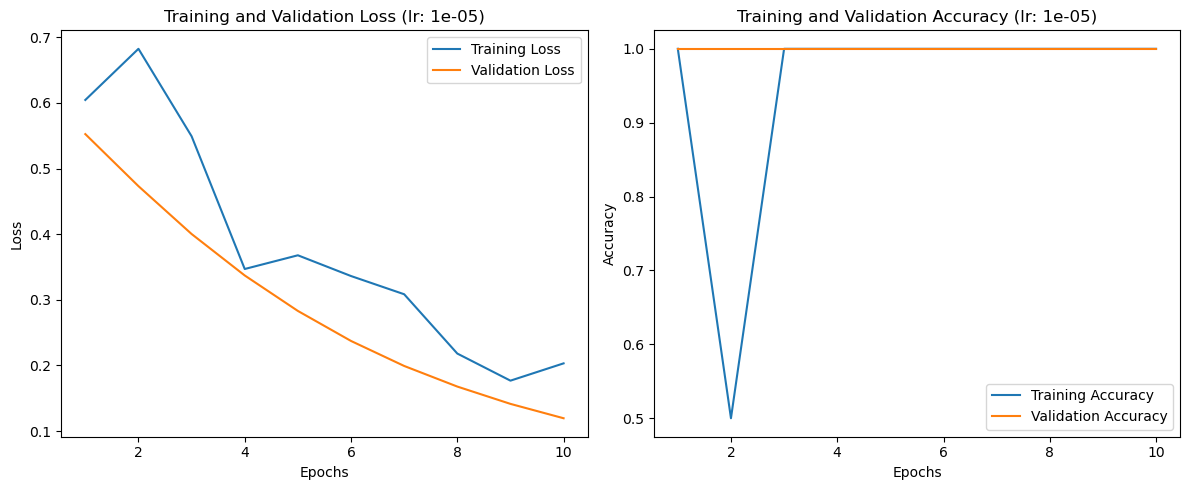

Epoch 1/10 - Training: 100%|██████████| 1/1 [00:00<00:00,  7.44batch/s]


Epoch [1/10], Training Loss: 0.6683, Training Accuracy: 0.5000


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 39.61batch/s, accuracy=0.5, loss=0.692]


new best model


Epoch 2/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.27batch/s]


Epoch [2/10], Training Loss: 0.5885, Training Accuracy: 1.0000


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 27.36batch/s, accuracy=1, loss=0.681]


new best model


Epoch 3/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 13.48batch/s]


Epoch [3/10], Training Loss: 0.6978, Training Accuracy: 0.5000


Epoch 3/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 32.00batch/s, accuracy=1, loss=0.67]


new best model


Epoch 4/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 12.82batch/s]


Epoch [4/10], Training Loss: 0.6958, Training Accuracy: 0.5000


Epoch 4/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 38.50batch/s, accuracy=1, loss=0.658]


new best model


Epoch 5/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.05batch/s]


Epoch [5/10], Training Loss: 0.6537, Training Accuracy: 0.5000


Epoch 5/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 28.35batch/s, accuracy=1, loss=0.646]


new best model


Epoch 6/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.42batch/s]


Epoch [6/10], Training Loss: 0.7023, Training Accuracy: 0.5000


Epoch 6/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 38.96batch/s, accuracy=1, loss=0.635]


new best model


Epoch 7/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 14.17batch/s]


Epoch [7/10], Training Loss: 0.5561, Training Accuracy: 1.0000


Epoch 7/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 27.36batch/s, accuracy=1, loss=0.623]


new best model


Epoch 8/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.42batch/s]


Epoch [8/10], Training Loss: 0.5232, Training Accuracy: 1.0000


Epoch 8/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 41.97batch/s, accuracy=1, loss=0.611]


new best model


Epoch 9/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.40batch/s]


Epoch [9/10], Training Loss: 0.7843, Training Accuracy: 0.5000


Epoch 9/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 43.04batch/s, accuracy=1, loss=0.599]


new best model


Epoch 10/10 - Training: 100%|██████████| 1/1 [00:00<00:00, 15.61batch/s]


Epoch [10/10], Training Loss: 0.6148, Training Accuracy: 0.5000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00, 40.29batch/s, accuracy=1, loss=0.588]

new best model


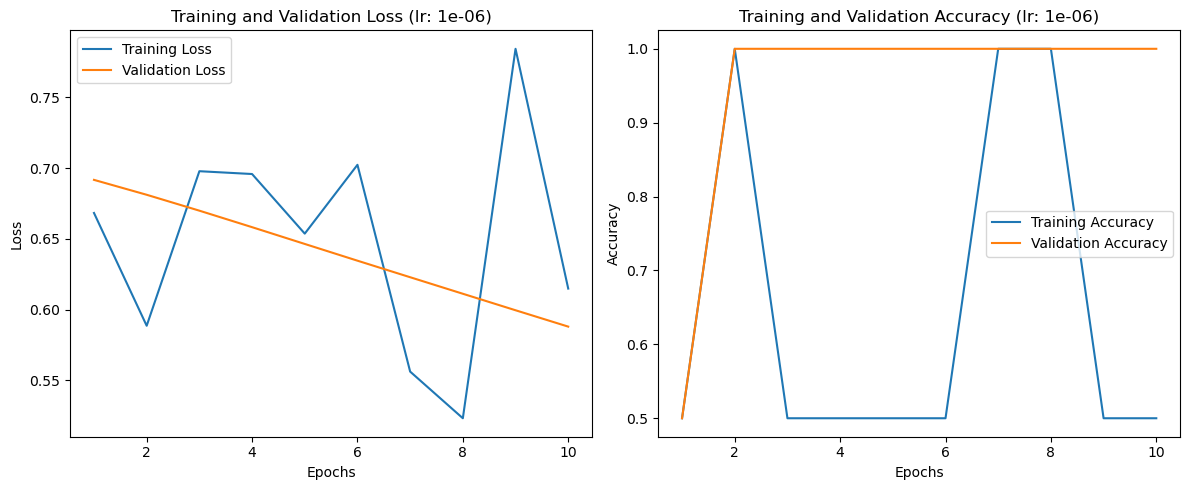

In [38]:
overfit_test(train_loader,val_loader,1e-2)
overfit_test(train_loader,val_loader,1e-3)
overfit_test(train_loader,val_loader,1e-4)
overfit_test(train_loader,val_loader,1e-5)
overfit_test(train_loader,val_loader,1e-6)